In [1]:
import os
from pathlib import Path

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import warnings
from rdkit import Chem
from rdkit import RDLogger
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Draw import MolsToGridImage
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split


DATA_PATH = Path("../data")
SEED = 42
TRAIN_SIZE = 0.85
BATCH_SIZE = 128

# Temporary suppress tf logs
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
# Temporary suppress warnings and RDKit logs
warnings.filterwarnings("ignore")
RDLogger.DisableLog("rdApp.*")

def seed_everything(seed=SEED):
    np.random.seed(seed)
    tf.random.set_seed(seed)
seed_everything(SEED)

In [2]:
import sys
sys.path.append("..")
from scripts.mpnn.utils import (
    AtomFeaturizer, BondFeaturizer, molecule_from_smiles, graph_from_molecule, graphs_from_smiles)
from scripts.mpnn.dataset import MPNNDataset
from scripts.mpnn.mpnn import MPNNModel

# Data

In [3]:
df = pd.read_csv(DATA_PATH / "base/train.csv").drop("Unnamed: 0", axis=1)
df.Active = df.Active.astype(int)

In [5]:
all_atoms = set()
all_hybridization = set()

for smiles in df.Smiles.values:
    mol = molecule_from_smiles(smiles)
    atoms = mol.GetAtoms()
    for a in atoms:
        all_atoms.add(a.GetSymbol())
        all_hybridization.add(a.GetHybridization())
        
print(all_atoms)
# print(all_hybridization)

{'Cl', 'S', 'Se', 'Zn', 'K', 'F', 'Ag', 'P', 'N', 'Na', 'Mg', 'C', 'Br', 'O', 'B', 'Si', 'I', 'Ca', 'Al', 'H', 'Sr', 'Li', 'As'}


In [7]:
test_atoms = set()
df = pd.read_csv(DATA_PATH / "base/test.csv").drop("Unnamed: 0", axis=1)
for smiles in df.Smiles.values:
    mol = molecule_from_smiles(smiles)
    atoms = mol.GetAtoms()
    for a in atoms:
        test_atoms.add(a.GetSymbol())
        
print(test_atoms)


{'Cl', 'P', 'N', 'I', 'Na', 'K', 'H', 'S', 'C', 'As', 'Br', 'Zn', 'O', 'F', 'B'}


In [8]:
test_atoms - all_atoms

set()

In [14]:
set(["B",
                "Br",
                "C",
                "Ca",
                "Cl",
                "F",
                "H",
                "I",
                "N",
                "Na",
                "O",
                "P",
                "S",
                "Ag",
                "Mg",
                "Se",
                "Zn",
                "As",
                "K"]) - all_atoms

set()

In [15]:
all_atoms - set(["B",
                "Br",
                "C",
                "Ca",
                "Cl",
                "F",
                "H",
                "I",
                "N",
                "Na",
                "O",
                "P",
                "S",
                "Ag",
                "Mg",
                "Se",
                "Zn",
                "As",
                "K"])

{'Al', 'Li', 'Si', 'Sr'}

In [8]:
all_atoms - {"B", "Br", "C", "Ca", "Cl", "F", "H", "I", "N", "Na", "O", "P", "S", "Ag", "Mg", "Se", "Zn"}

{'As', 'K'}

In [5]:
atom_featurizer = AtomFeaturizer(
    allowable_sets={
        "symbol": {"B", "Br", "C", "Ca", "Cl", "F", "H", "I", "N", "Na", "O", "P", "S", "Ag", "Mg", "Se", "Zn"},
        # "symbol": {"B", "Br", "C", "Ca", "Cl", "F", "H", "I", "N", "Na", "O", "P", "S"},
        "n_valence": {0, 1, 2, 3, 4, 5, 6},
        "n_hydrogens": {0, 1, 2, 3, 4},
        "hybridization": {"s", "sp", "sp2", "sp3"},
    }
)

bond_featurizer = BondFeaturizer(
    allowable_sets={
        "bond_type": {"single", "double", "triple", "aromatic"},
        "conjugated": {True, False},
    }
)

In [6]:
%%time

# Shuffle array of indices ranging from 0 to df.shape[0]
permuted_indices = np.random.permutation(np.arange(df.shape[0]))

# Train set: 80% of data
train_index = permuted_indices[: int(df.shape[0] * TRAIN_SIZE)]
x_train = graphs_from_smiles(df.iloc[train_index].Smiles, atom_featurizer, bond_featurizer)
y_train = df.iloc[train_index].Active

# Valid set: 10 % of data
# valid_index = permuted_indices[int(df.shape[0] * TRAIN_SIZE) : int(df.shape[0] * 0.9)]
valid_index = permuted_indices[int(df.shape[0] * TRAIN_SIZE):]
x_valid = graphs_from_smiles(df.iloc[valid_index].Smiles, atom_featurizer, bond_featurizer)
y_valid = df.iloc[valid_index].Active

# # Test set: 10 % of data
# test_index = permuted_indices[int(df.shape[0] * 0.9) :]
# x_test = graphs_from_smiles(df.iloc[test_index].Smiles, atom_featurizer, bond_featurizer)
# y_test = df.iloc[test_index].Active


CPU times: user 14.7 s, sys: 200 ms, total: 14.9 s
Wall time: 15 s


Num:	3367
SMILES:	CCCc1c2oc(C(=O)O)cc(=O)c2cc2c(=O)cc(C(=O)O)n(CC)c12
Active:	0
Molecule:


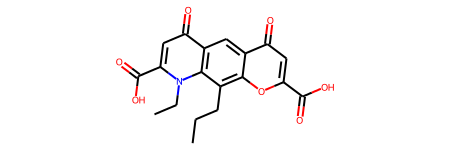

In [7]:
c = np.random.randint(0, len(df))
print(f"Num:\t{c}\nSMILES:\t{df.Smiles[c]}\nActive:\t{df.Active[c]}")
molecule = molecule_from_smiles(df.iloc[c].Smiles)
print("Molecule:")
molecule

In [8]:
graph = graph_from_molecule(molecule, atom_featurizer, bond_featurizer)
print("Graph (including self-loops):")
print(" atom features\t", graph[0].shape)
print(" bond features\t", graph[1].shape)
print(" pair indices\t", graph[2].shape)

Graph (including self-loops):
 atom features	 (27, 33)
 bond features	 (85, 7)
 pair indices	 (85, 2)


# Model

In [9]:
def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2 * ((p * r) / (p + r + K.epsilon()))

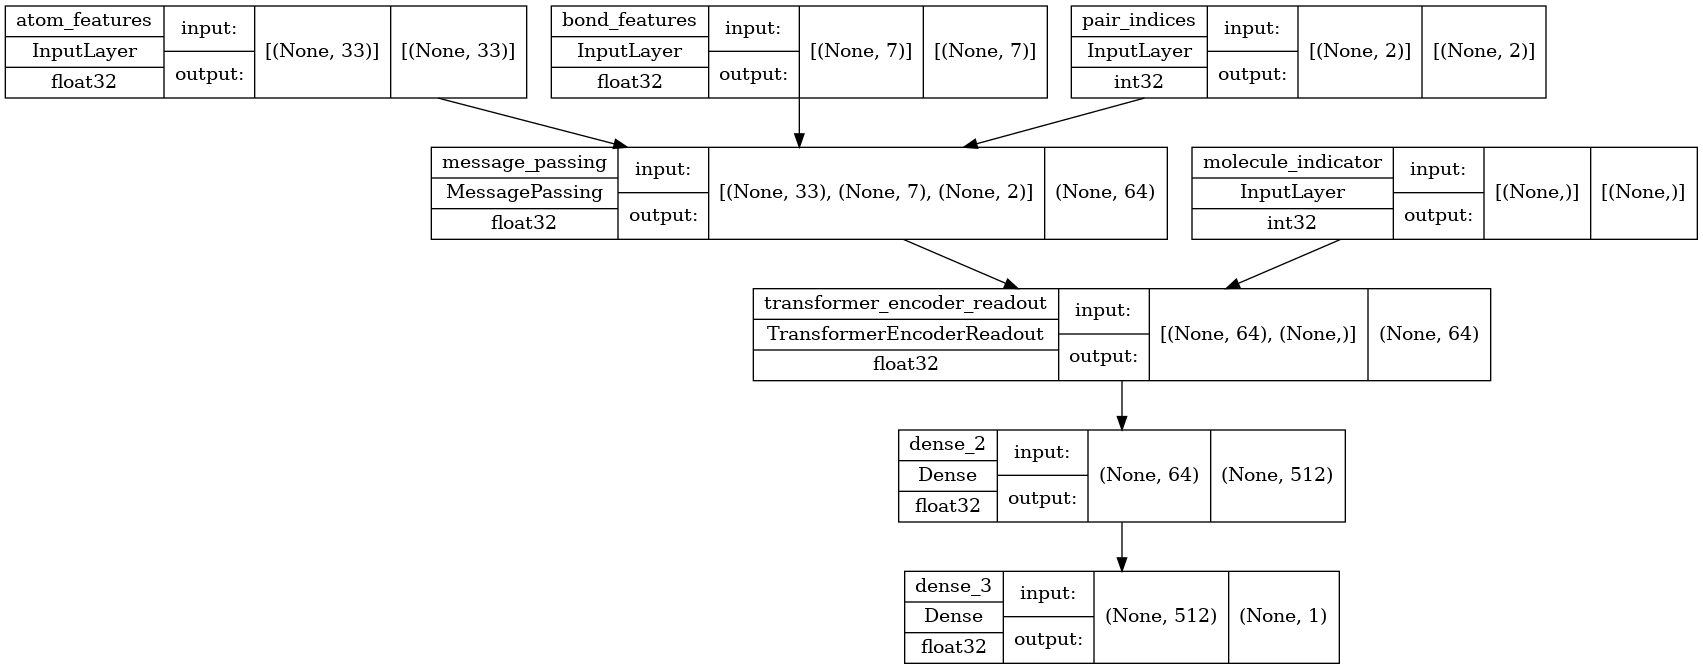

In [10]:
mpnn = MPNNModel(
    atom_dim=x_train[0][0][0].shape[0], 
    bond_dim=x_train[1][0][0].shape[0],
    batch_size=BATCH_SIZE,
    message_units=64,
    message_steps=4,
    num_attention_heads=8,
    dense_units=512,
)
mpnn.load_weights("../mpnn_100_epochs.h5")

mpnn.compile(
    loss=keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    metrics=[f1],
)

keras.utils.plot_model(mpnn, show_dtype=True, show_shapes=True)

# Train

In [11]:
df.Active.value_counts()

0    5351
1     206
Name: Active, dtype: int64

In [12]:
5351 / 206

25.975728155339805

In [13]:
N_EPOCHS = 200
CLASS_WEIGHTS = {0: 1, 1: 26}

In [14]:
tf.config.list_physical_devices('GPU')

[]

In [15]:
train_dataset = MPNNDataset(x_train, y_train, batch_size=BATCH_SIZE)
valid_dataset = MPNNDataset(x_valid, y_valid, batch_size=BATCH_SIZE)
# test_dataset = MPNNDataset(x_test, y_test, batch_size=BATCH_SIZE)

history = mpnn.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=N_EPOCHS,
    verbose=1,
    class_weight=CLASS_WEIGHTS,
)

Epoch 1/200
37/37 [==============================] - 37s 870ms/step - loss: 1.0676 - f1: 0.2222 - val_loss: 0.4904 - val_f1: 0.2418
Epoch 2/200
37/37 [==============================] - 29s 788ms/step - loss: 1.0456 - f1: 0.2134 - val_loss: 0.4664 - val_f1: 0.2955
Epoch 3/200
37/37 [==============================] - 29s 798ms/step - loss: 1.0337 - f1: 0.2183 - val_loss: 0.4534 - val_f1: 0.2685
Epoch 4/200
37/37 [==============================] - 29s 773ms/step - loss: 1.0362 - f1: 0.2092 - val_loss: 0.4377 - val_f1: 0.2821
Epoch 5/200
37/37 [==============================] - 31s 840ms/step - loss: 1.0071 - f1: 0.2328 - val_loss: 0.4510 - val_f1: 0.2527
Epoch 6/200
37/37 [==============================] - 31s 834ms/step - loss: 0.9991 - f1: 0.2280 - val_loss: 0.4167 - val_f1: 0.2843
Epoch 7/200
28/37 [=====================>........] - ETA: 6s - loss: 1.0160 - f1: 0.2154

KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(history.history["f1"], label="train f1")
plt.plot(history.history["val_f1"], label="valid f1")
plt.xlabel("Epochs", fontsize=16)
plt.ylabel("F1", fontsize=16)
plt.legend(fontsize=16)

In [ ]:
mpnn.save_weights('mpnn.h5')

In [16]:
df_test = pd.read_csv(DATA_PATH / "base/test.csv").drop("Unnamed: 0", axis=1)
x_test = graphs_from_smiles(df_test.Smiles, atom_featurizer, bond_featurizer)

In [25]:
test_dataset = MPNNDataset(x_test, [0] * len(df_test), batch_size=BATCH_SIZE)

In [33]:
y_pred = tf.math.round(tf.squeeze(mpnn.predict(test_dataset), axis=1))

In [34]:
len(y_pred)

1614

In [35]:
df_test["Active"] = y_pred

In [36]:
df_test.to_csv("submission_mpnn.csv", index=False)